In [1]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, f1_score, recall_score
import numpy as np
from scipy.stats import sem, t

def eval_std_ci(truth_df, hyps_df, result_df):
    f1_scores = []
    sensitivities = []
    specificities = []
    aucs = []
    fold_indices = [(0, 17), (17, 35), (35, 52), (52, 69), (69, 86)]

    for start, end in fold_indices:
        truth = np.array(truth_df[start:end])
        hyps = np.array(hyps_df[start:end])
        # hyps_binary = (hyps >= 0.5).astype(int)
        hyps_binary = np.array(result_df[start:end])

        f1 = f1_score(truth, hyps_binary)
        f1_scores.append(f1)
        sensitivity = recall_score(truth, hyps_binary)
        sensitivities.append(sensitivity)
        cm = confusion_matrix(truth, hyps_binary)
        tn = cm[0, 0]
        fp = cm[0, 1]
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        specificities.append(specificity)
        fpr, tpr, _ = roc_curve(truth, hyps, pos_label=1)
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    mean_sensitivity = np.mean(sensitivities)
    std_sensitivity = np.std(sensitivities)
    mean_specificity = np.mean(specificities)
    std_specificity = np.std(specificities)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    conf_interval_f1 = t.interval(0.95, len(f1_scores)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1_scores)))
    conf_interval_sensitivity = t.interval(0.95, len(sensitivities)-1, loc=mean_sensitivity, scale=std_sensitivity/np.sqrt(len(sensitivities)))
    conf_interval_specificity = t.interval(0.95, len(specificities)-1, loc=mean_specificity, scale=std_specificity/np.sqrt(len(specificities)))
    conf_interval_auc = t.interval(0.95, len(aucs)-1, loc=mean_auc, scale=std_auc/np.sqrt(len(aucs)))

    def adjust_confidence_interval(conf_interval):
        return (max(0, min(conf_interval[0], 1)), max(0, min(conf_interval[1], 1)))

    conf_interval_f1 = adjust_confidence_interval(conf_interval_f1)
    conf_interval_sensitivity = adjust_confidence_interval(conf_interval_sensitivity)
    conf_interval_specificity = adjust_confidence_interval(conf_interval_specificity)
    conf_interval_auc = adjust_confidence_interval(conf_interval_auc)


    return f1_scores, sensitivities, specificities, aucs, mean_f1, mean_sensitivity, mean_specificity, mean_auc, std_f1, std_sensitivity, std_specificity, std_auc, conf_interval_f1, conf_interval_sensitivity, conf_interval_specificity, conf_interval_auc

## eGeMAPS

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class Para(object):
    a=1

def find_file(x):
        # return int(x.split('/')[-1].replace("CTT.wav", ""))
        return int(x.split('\\')[-1].replace("CTT.wav", ""))

def file_str(x):
    return int(x.replace("CTT", ""))

def find_5fold(x):
    return x[x.find("CTT5-")+5]
    
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
#force_cudnn_initialization()
def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    df1 = pd.read_csv('preprocess_input_CTT5_2_e_16.csv')
    # df1 = pd.read_csv('preprocess_input_pause.csv')
    df1['find_5fold'] = df1['file'].map(find_5fold)
    df1['file'] = df1['file'].map(find_file)
    df1 = df1.sort_values(by='file', ascending=True)
    df1.set_index("file" , inplace=True)
    df3 = df1.iloc[:,-1]
    df1 = df1.drop(columns = ['start', 'end', 'find_5fold'])

    df2 = pd.read_csv('data/biclass2.txt', sep=' ')
    df2['file']=df2['file'].map(file_str)
    df2.set_index("file" , inplace=True)

    feature = df1.to_numpy()
#     feature = torch.from_numpy(feature_numpy.astype(np.float32))

    target = df2.to_numpy()
#     target = torch.from_numpy(target_numpy.astype(np.float32))
#     target = target.view(target.shape[0], 1)

    n_samples, n_features = feature.shape
    print(n_samples, n_features)
    
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        idx = 0
#         df =pd.DataFrame()
        for i in (df3.index):
            if(int(df3[i]) != fold+1):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                name.append(i)
            idx += 1

        train = np.array(train)
        train = torch.from_numpy(train.astype(np.float32))

        t_tra = np.array(t_tra)
        t_tra = torch.from_numpy(t_tra.astype(int))
        t_tra = t_tra.view(t_tra.shape[0], 1)
        
        valid = np.array(valid)
        valid = torch.from_numpy(valid.astype(np.float32))

        t_val = np.array(t_val)
        t_val = torch.from_numpy(t_val.astype(int))
        t_val = t_val.view(t_val.shape[0], 1)
        
        name = np.array(name)
        name = torch.from_numpy(name.astype(int))
        
        print("fold: ", fold)
        
        n_samples, n_features = train.shape
#         print(n_samples, n_features)
        n_samples, n_features = valid.shape
#         print(n_samples, n_features)

#         clf = SVC(kernel='linear')
        svc = SVC(kernel='linear', C=1, probability=True, random_state=1)
        clf = make_pipeline(StandardScaler(), svc)

        # Fit the model to the data
        clf.fit(train, t_tra.ravel())
#         print(reg.coef_)
        y_predicted = clf.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = clf.predict(valid)
        y_predicted_val_pro = clf.predict_proba(valid)
        y_predicted_val_pro = [row[1] for row in y_predicted_val_pro]
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)
        
#         print(t_val.ravel())
        y_predicted_val = torch.from_numpy(y_predicted_val.astype(int))
        y_predicted_val = y_predicted_val.view(y_predicted_val.shape[0], 1)
        y_predicted_val_pro = np.reshape(y_predicted_val_pro, (-1,))
#         print(y_predicted_val.ravel())
        
        top = 10
        imp = svc.coef_
        imp = abs(imp[0])
        names = df1.columns

        import opensmile
        smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
        )        
        group_names = smile.feature_names
        group_imp = np.zeros(len(group_names))
        print(len(names), len(group_names))
        # print(names)
        # print(group_names)
        
        for idx, gf in enumerate(group_names):
            if(gf.find("slope") != -1):
                gf = gf.replace("slope", "slopeV")
            for i, n in zip(imp, names):
                # print(n, gf)
                if(n.lower().find(gf.split("_")[-2].lower()) != -1):
                    group_imp[idx] += i
                    # print("GET")
            if(gf.find("slope") != -1):
                gf = gf.replace("slopeV", "slopeUV")
            for i, n in zip(imp, names):
                # print(n, gf)
                if(n.lower().find(gf.split("_")[-2].lower()) != -1):
                    group_imp[idx] += i
                    # print("GET")
            
        print(imp)
        print(group_imp)

        # imp,names = zip(*sorted(zip(imp,names), reverse=True))
        # # plt.barh(range(len(names)), imp, align='center')
        # # plt.yticks(range(len(names)), names)
        # plt.barh(range(top), imp[:top][::-1], align='center')
        # plt.yticks(range(top), names[:top][::-1])
        # plt.show()

        group_imp,group_names = zip(*sorted(zip(group_imp,group_names), reverse=True))
        plt.barh(range(top), group_imp[:top][::-1], align='center')
        plt.yticks(range(top), group_names[:top][::-1])
        plt.show()

        df = pd.DataFrame(
            {'name': name,
             'result': torch.flatten(y_predicted_val).detach().numpy(),
             'truth': torch.flatten(t_val).detach().numpy(),
             'hyps': y_predicted_val_pro
            })
        alldf = pd.concat([alldf, df])
#         print(df)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_acoustic_e.csv', index=False)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_pause_e.csv', index=False)
    # alldf.to_csv(f'biclass_result/5folds_biclass_acoustic_e.csv', index=False) 
    alldf.to_csv(f'biclass_result/acoustic_e.csv', index=False) 
    return True


0


start
86 88
fold:  0
88 25
[0.04831163 0.43351107 0.10583631 0.1409214  0.04956744 0.062664
 0.16791482 0.01955171 0.05972405 0.13984957 0.06915724 0.44784635
 0.47847384 0.46357881 0.04990655 0.04409355 0.13393062 0.31506032
 0.17332077 0.25492643 0.3200696  0.00616146 0.21720051 0.10523873
 0.52251858 0.03194748 0.56864347 0.18923119 0.21741011 0.06944715
 0.4979291  0.20760708 0.03411909 0.33687412 0.18110379 0.04835506
 0.41480268 0.3633293  0.03328176 0.1515911  0.0739585  0.17205171
 0.23509438 0.03272806 0.04907879 0.03602986 0.13394757 0.04990806
 0.18150336 0.10778468 0.06842026 0.06839511 0.05842335 0.09524938
 0.35883018 0.12046287 0.06206265 0.06193463 0.00930822 0.10258212
 0.15188894 0.08796361 0.11433413 0.2872363  0.2093811  0.42296653
 0.22883087 0.33797791 0.05030433 0.03048224 0.41546942 0.21517419
 0.09069604 0.44634992 0.05107692 0.34308194 0.61822823 0.14868551
 0.08624993 0.38617252 0.13908818 0.16512513 0.13394343 0.38210175
 0.20269532 0.16063363 0.10160381 0.1

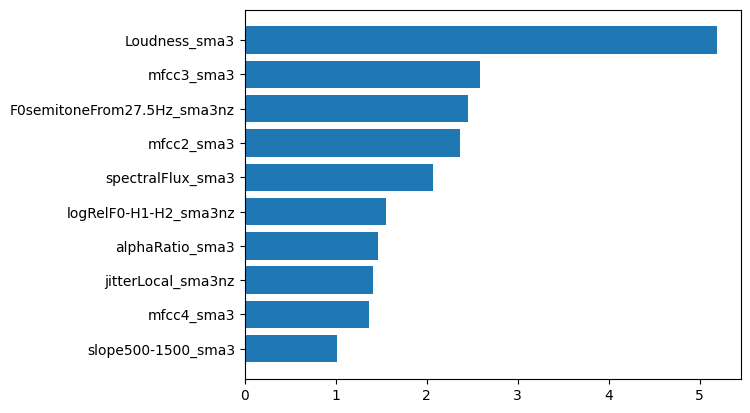

fold:  1
88 25
[0.03639959 0.40979757 0.06073318 0.00593044 0.02784085 0.12444575
 0.07989942 0.06145756 0.08275344 0.10365449 0.00794812 0.3697069
 0.4402846  0.51138177 0.02257712 0.02921698 0.11132288 0.04070945
 0.11452807 0.10126323 0.11341448 0.27137946 0.17233353 0.11326627
 0.26410634 0.05249663 0.27814093 0.20106064 0.08134507 0.05973815
 0.34923789 0.15185572 0.14930751 0.05994462 0.1786899  0.13238182
 0.29498757 0.2465535  0.20228183 0.15113579 0.15786288 0.24896695
 0.03042391 0.00844197 0.00198604 0.00956822 0.04361784 0.02448277
 0.074658   0.23644311 0.00079293 0.02365892 0.04352604 0.03140121
 0.1885826  0.07891497 0.00519618 0.01667859 0.09593563 0.09489368
 0.08691165 0.05287813 0.0648027  0.12535066 0.16686284 0.13402592
 0.02472393 0.10707678 0.00596069 0.05946182 0.21165855 0.25757686
 0.34608678 0.41368633 0.05464784 0.06177555 0.38171413 0.22927721
 0.11438005 0.09188464 0.00835754 0.27919555 0.00926658 0.16349196
 0.02573886 0.01376891 0.11890606 0.0371572 ]
[4

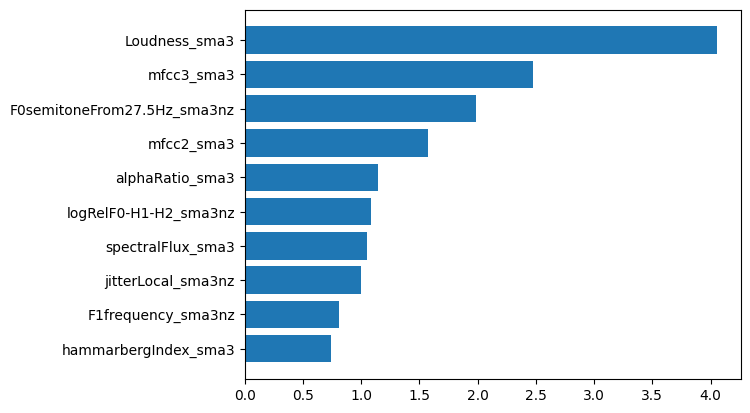

fold:  2
88 25
[0.04810985 0.48967191 0.04372374 0.09178589 0.03363029 0.11446255
 0.19570695 0.16936099 0.13012811 0.04319026 0.02911735 0.36567698
 0.2933035  0.05208719 0.03937021 0.03566831 0.10495034 0.3949246
 0.058727   0.11160018 0.24817953 0.01561833 0.09425066 0.13880552
 0.57377145 0.1914665  0.14122309 0.19814451 0.26708588 0.06024027
 0.1726809  0.25114044 0.06032644 0.10203949 0.31652916 0.02913903
 0.30992041 0.3034257  0.01630274 0.06914408 0.06210694 0.03215827
 0.22132823 0.07981474 0.13493264 0.02276666 0.00771653 0.0819848
 0.0467894  0.04560352 0.11239946 0.01804857 0.09252675 0.00734836
 0.01220626 0.20351813 0.10706012 0.0097565  0.00636717 0.20758762
 0.04865275 0.01839069 0.14642174 0.1533223  0.26055439 0.32217288
 0.2526214  0.25873533 0.14473214 0.17254159 0.33951949 0.07188704
 0.0303264  0.57021632 0.26337981 0.27166794 0.66167291 0.48899513
 0.05928987 0.12099979 0.23854321 0.14585108 0.06904132 0.26993345
 0.18306678 0.16140199 0.11552224 0.02962181]
[3.

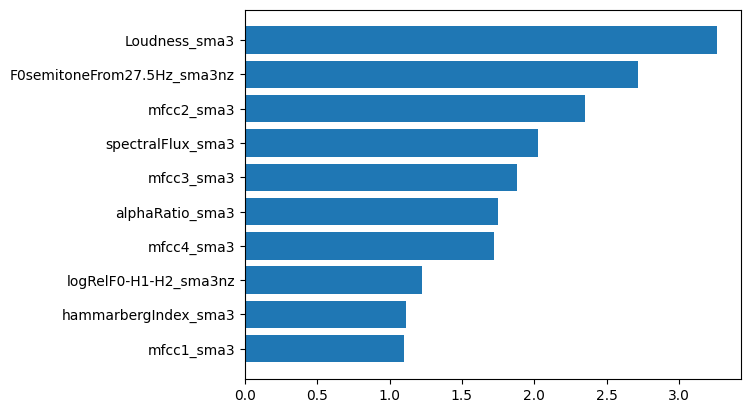

fold:  3
88 25
[0.01088085 0.64212685 0.08831965 0.05413733 0.15595303 0.16322966
 0.08237    0.18941652 0.01700575 0.09998685 0.03159943 0.3245697
 0.45696339 0.49212294 0.00671964 0.01257848 0.10902453 0.2430107
 0.17411152 0.11443076 0.22506858 0.08718907 0.1368557  0.0396198
 0.55490505 0.16156793 0.47472446 0.16334333 0.31022784 0.02817621
 0.40992779 0.10792117 0.15817387 0.11364898 0.28159688 0.00751151
 0.28188269 0.63117932 0.05434874 0.0642396  0.11516376 0.1645825
 0.17868186 0.05670621 0.05964503 0.07235274 0.02838589 0.02418525
 0.02453557 0.14587748 0.03766058 0.07750217 0.12589373 0.03368453
 0.0142541  0.03677136 0.04113582 0.08666247 0.13023741 0.00333579
 0.0167687  0.16415076 0.15173203 0.15109249 0.51091925 0.33420376
 0.27235686 0.21859634 0.02412917 0.09870048 0.27886405 0.04738065
 0.2397961  0.30388826 0.07063866 0.36258872 0.26990776 0.06436385
 0.20565068 0.36611204 0.20102475 0.33698027 0.08356227 0.00524479
 0.02475519 0.12224939 0.05347487 0.07997577]
[4.60

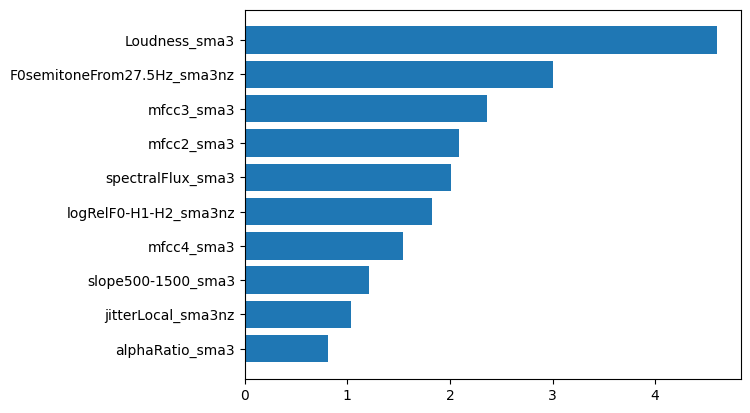

fold:  4
88 25
[0.03721727 0.61130053 0.10100776 0.01615893 0.14286543 0.11969175
 0.14579592 0.12484755 0.09318133 0.15718956 0.03166053 0.44979169
 0.53026141 0.50750582 0.01499705 0.00779837 0.1583016  0.40217459
 0.18895629 0.35611385 0.17403327 0.10694595 0.20489808 0.03890553
 0.6389133  0.10837134 0.35344595 0.15404356 0.23500651 0.23164612
 0.40423047 0.02233018 0.06743701 0.12505053 0.0924531  0.1176382
 0.24316315 0.51030739 0.05125972 0.04216799 0.0192957  0.0564355
 0.32725082 0.08307231 0.06813272 0.00364448 0.07941735 0.04875163
 0.13139549 0.24786479 0.02026787 0.02085531 0.18636223 0.00279917
 0.03484515 0.07768879 0.03221897 0.00083043 0.05496487 0.01874894
 0.04727708 0.07875735 0.07962897 0.17906637 0.20759112 0.39311638
 0.10615288 0.55978541 0.07500908 0.2422998  0.39459633 0.19509611
 0.06563263 0.50764101 0.11126558 0.40089153 0.53015783 0.23256697
 0.14369619 0.34326646 0.60265618 0.44160994 0.11430506 0.12484047
 0.08595829 0.01763248 0.05984387 0.03726622]
[6.

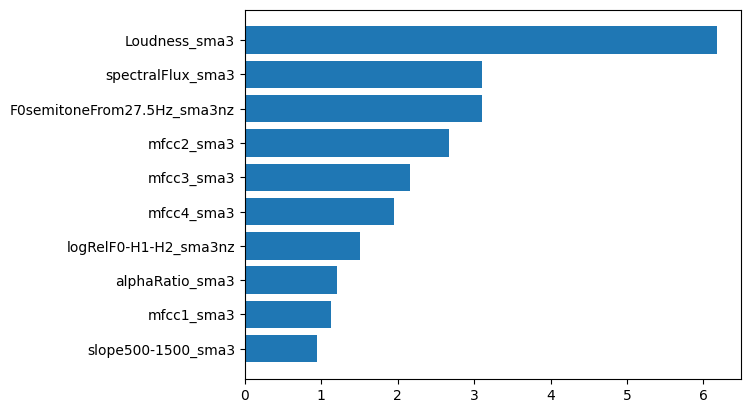

True

In [2]:
# res = False
# import time
# while (res == False):
# #     print(res)
#     time.sleep(2)
#     try:
#         res = main()
#     except:
#         continue
main()

In [3]:
import pandas as pd
fivefolds_1k_e = pd.read_csv('biclass_result/acoustic_e.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
fivefolds_1k_e.head(50)

,name,result,truth,hyps
0,15,0,0,0.259314
1,16,1,1,0.567440
2,22,1,0,0.411315
3,28,1,1,0.696339
4,34,0,0,0.360968
5,35,1,1,0.599616
6,40,1,1,0.653680
7,42,0,0,0.336677
8,51,0,0,0.351493
9,53,1,0,0.428734


In [4]:
fivefolds_1k_e.tail(38)

,name,result,truth,hyps
48,82,0,0,0.184891
49,87,0,0,0.213364
50,93,1,0,0.373433
51,98,0,0,0.205837
52,4,1,1,0.996026
53,6,1,0,0.443881
54,7,0,0,0.001075
55,9,1,1,0.466940
56,12,0,1,0.311800
57,17,0,1,0.008907


In [5]:
fivefolds_1_result_e = fivefolds_1k_e['result'].tolist()
fivefolds_1_hyps_e = fivefolds_1k_e['hyps'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
fivefolds_1_truth_e = fivefolds_1k_e['truth'].tolist()

In [7]:
from sklearn import metrics

target_names = ['non-patient', 'patient']
clf_report = metrics.classification_report(fivefolds_1_truth_e, fivefolds_1_result_e, target_names=target_names)
print(clf_report)
tn, fp, fn, tp = metrics.confusion_matrix(fivefolds_1_truth_e, fivefolds_1_result_e).ravel()
print('sensitivuty: ',tp / (fn+tp))
print('specificity: ',tn / (fp+tn))
# fpr, tpr, thresholds = metrics.roc_curve(np.array(fivefolds_1_truth_e), np.array(fivefolds_1_hyps_e), pos_label=1)
# print('AUC: ',metrics.auc(fpr, tpr))

# fpr, tpr, thresholds = metrics.roc_curve(np.array(fivefolds_1_truth_e), np.array(fivefolds_1_hyps_e), pos_label=1)
# print('AUC: ',metrics.auc(fpr, tpr))
# fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(fivefolds_1_truth_e[0:19]), np.array(fivefolds_1_hyps_e[0:19]), pos_label=1)
# auc1 = metrics.auc(fpr1, tpr1)
# fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(fivefolds_1_truth_e[19:37]), np.array(fivefolds_1_hyps_e[19:37]), pos_label=1)
# auc2 = metrics.auc(fpr2, tpr2)
# fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(fivefolds_1_truth_e[37:54]), np.array(fivefolds_1_hyps_e[37:54]), pos_label=1)
# auc3 = metrics.auc(fpr3, tpr3)
# fpr4, tpr4, thresholds4 = metrics.roc_curve(np.array(fivefolds_1_truth_e[54:71]), np.array(fivefolds_1_hyps_e[54:71]), pos_label=1)
# auc4 = metrics.auc(fpr4, tpr4)
# fpr5, tpr5, thresholds5 = metrics.roc_curve(np.array(fivefolds_1_truth_e[71:88]), np.array(fivefolds_1_hyps_e[71:88]), pos_label=1)
# auc5 = metrics.auc(fpr5, tpr5)
# print('AUC: ', auc1, auc2, auc3, auc4, auc5)
# print("AUC_avg: ", (auc1+auc2+auc3+auc4+auc5)/5)

f1_scores, sensitivities, specificities, aucs, \
mean_f1, mean_sensitivity, mean_specificity, mean_auc, \
std_f1, std_sensitivity, std_specificity, std_auc, \
conf_interval_f1, conf_interval_sensitivity, conf_interval_specificity, conf_interval_auc = eval_std_ci(fivefolds_1_truth_e, fivefolds_1_hyps_e, fivefolds_1_result_e)
print(f"F1 Scores: {f1_scores}, Sensitivities: {sensitivities}, Specificities: {specificities}, AUCs: {aucs}")
print(f"Mean F1 Score: {mean_f1}, Std Dev: {std_f1}, 95% Confidence Interval: {conf_interval_f1}")
print(f"Mean Sensitivity: {mean_sensitivity}, Std Dev: {std_sensitivity}, 95% Confidence Interval: {conf_interval_sensitivity}")
print(f"Mean Specificity: {mean_specificity}, Std Dev: {std_specificity}, 95% Confidence Interval: {conf_interval_specificity}")
print(f"Mean AUC: {mean_auc}, Std Dev: {std_auc}, 95% Confidence Interval: {conf_interval_auc}")

              precision    recall  f1-score   support

 non-patient       0.87      0.78      0.82        58
     patient       0.62      0.75      0.68        28

    accuracy                           0.77        86
   macro avg       0.74      0.76      0.75        86
weighted avg       0.78      0.77      0.77        86

sensitivuty:  0.75
specificity:  0.7758620689655172
F1 Scores: [0.6666666666666666, 0.75, 0.5454545454545454, 0.6, 0.7692307692307693], Sensitivities: [1.0, 0.75, 0.5, 0.6, 1.0], Specificities: [0.6923076923076923, 0.8, 0.8181818181818182, 0.8333333333333334, 0.75], AUCs: [0.9615384615384616, 0.8125, 0.7272727272727273, 0.75, 0.95]
Mean F1 Score: 0.6662703962703962, Std Dev: 0.08555685501615382, 95% Confidence Interval: (0.5600375295972987, 0.7725032629434937)
Mean Sensitivity: 0.77, Std Dev: 0.20396078054371136, 95% Confidence Interval: (0.5167492417533344, 1)
Mean Specificity: 0.7787645687645688, Std Dev: 0.051545329683355116, 95% Confidence Interval: (0.71476258

## ComParE

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class Para(object):
    a=1

def find_file(x):
        # return int(x.split('/')[-1].replace("CTT.wav", ""))
        return int(x.split('\\')[-1].replace("CTT.wav", ""))

def file_str(x):
    return int(x.replace("CTT", ""))

def find_5fold(x):
    return x[x.find("CTT5-")+5]
    
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
#force_cudnn_initialization()
def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    df1 = pd.read_csv('preprocess_input_CTT5_2_c_16.csv')
    # df1 = pd.read_csv('preprocess_input_pause.csv')
    df1['find_5fold'] = df1['file'].map(find_5fold)
    df1['file'] = df1['file'].map(find_file)
    df1 = df1.sort_values(by='file', ascending=True)
    df1.set_index("file" , inplace=True)
    df3 = df1.iloc[:,-1]
    df1 = df1.drop(columns = ['start', 'end', 'find_5fold'])

    df2 = pd.read_csv('data/biclass2.txt', sep=' ')
    df2['file']=df2['file'].map(file_str)
    df2.set_index("file" , inplace=True)

    feature = df1.to_numpy()
#     feature = torch.from_numpy(feature_numpy.astype(np.float32))

    target = df2.to_numpy()
#     target = torch.from_numpy(target_numpy.astype(np.float32))
#     target = target.view(target.shape[0], 1)

    n_samples, n_features = feature.shape
    print(n_samples, n_features)
    
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        idx = 0
#         df =pd.DataFrame()
        for i in (df3.index):
            if(int(df3[i]) != fold+1):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                name.append(i)
            idx += 1

        train = np.array(train)
        train = torch.from_numpy(train.astype(np.float32))

        t_tra = np.array(t_tra)
        t_tra = torch.from_numpy(t_tra.astype(int))
        t_tra = t_tra.view(t_tra.shape[0], 1)
        
        valid = np.array(valid)
        valid = torch.from_numpy(valid.astype(np.float32))

        t_val = np.array(t_val)
        t_val = torch.from_numpy(t_val.astype(int))
        t_val = t_val.view(t_val.shape[0], 1)
        
        name = np.array(name)
        name = torch.from_numpy(name.astype(int))
        
        print("fold: ", fold)
        
        n_samples, n_features = train.shape
#         print(n_samples, n_features)
        n_samples, n_features = valid.shape
#         print(n_samples, n_features)

#         clf = SVC(kernel='linear')
        svc = SVC(kernel='linear', C=1, probability=True, random_state=1)
        clf = make_pipeline(StandardScaler(), svc)

        # Fit the model to the data
        clf.fit(train, t_tra.ravel())
#         print(reg.coef_)
        y_predicted = clf.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = clf.predict(valid)
        y_predicted_val_pro = clf.predict_proba(valid)
        y_predicted_val_pro = [row[1] for row in y_predicted_val_pro]
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)
        
#         print(t_val.ravel())
        y_predicted_val = torch.from_numpy(y_predicted_val.astype(int))
        y_predicted_val = y_predicted_val.view(y_predicted_val.shape[0], 1)
        y_predicted_val_pro = np.reshape(y_predicted_val_pro, (-1,))
#         print(y_predicted_val.ravel())
        
        top = 10
        imp = svc.coef_
        imp = abs(imp[0])
        names = df1.columns

        import opensmile
        smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.ComParE_2016,
            feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
        )        
        group_names = smile.feature_names
        group_imp = np.zeros(len(group_names))
        print(len(names), len(group_names))
        # print(names)
        # print(group_names)
        
        for idx, gf in enumerate(group_names):
            for i, n in zip(imp, names):
                # print(n, gf)
                if(n.lower().find(gf.lower()) != -1):
                    group_imp[idx] += i
                    # print("GET")
            
        print(imp)
        print(group_imp)

        # imp,names = zip(*sorted(zip(imp,names), reverse=True))
        # # plt.barh(range(len(names)), imp, align='center')
        # # plt.yticks(range(len(names)), names)
        # plt.barh(range(top), imp[:top][::-1], align='center')
        # plt.yticks(range(top), names[:top][::-1])
        # plt.show()

        group_imp,group_names = zip(*sorted(zip(group_imp,group_names), reverse=True))
        plt.barh(range(top), group_imp[:top][::-1], align='center')
        plt.yticks(range(top), group_names[:top][::-1])
        plt.show()

        df = pd.DataFrame(
            {'name': name,
             'result': torch.flatten(y_predicted_val).detach().numpy(),
             'truth': torch.flatten(t_val).detach().numpy(),
             'hyps': y_predicted_val_pro
            })
        alldf = pd.concat([alldf, df])
#         print(df)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_acoustic_c.csv', index=False)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_pause_c.csv', index=False)
    # alldf.to_csv(f'biclass_result/5folds_biclass_acoustic_c.csv', index=False) 
    alldf.to_csv(f'biclass_result/acoustic_c.csv', index=False) 
    return True


0


start
86 6373
fold:  0
6373 65
[0.00045706 0.00177925 0.00307523 ... 0.0028906  0.00038436 0.00177443]
[0.11868288 0.1516029  0.12358362 0.12784112 0.10043908 0.12043286
 0.09466766 0.08446672 0.10286734 0.1039031  0.061374   0.03682472
 0.05958705 0.05938269 0.05250662 0.05959523 0.0425236  0.05375247
 0.06436647 0.05004908 0.05012312 0.03633376 0.06744961 0.06543562
 0.05788535 0.04877718 0.05035009 0.03539189 0.06026191 0.0541593
 0.05332448 0.04130986 0.0667881  0.06232354 0.07409853 0.06850941
 0.10059648 0.16044841 0.13255472 0.09640381 0.08836408 0.10219342
 0.10621924 0.10149021 0.19843212 0.10367641 0.13672991 0.17130383
 0.11583481 0.1023343  0.10405661 0.10565413 0.07277587 0.07513207
 0.09281804 0.10221185 0.0609654  0.08446452 0.06991646 0.0638707
 0.06281029 0.04617558 0.06491217 0.05940014 0.08800502]


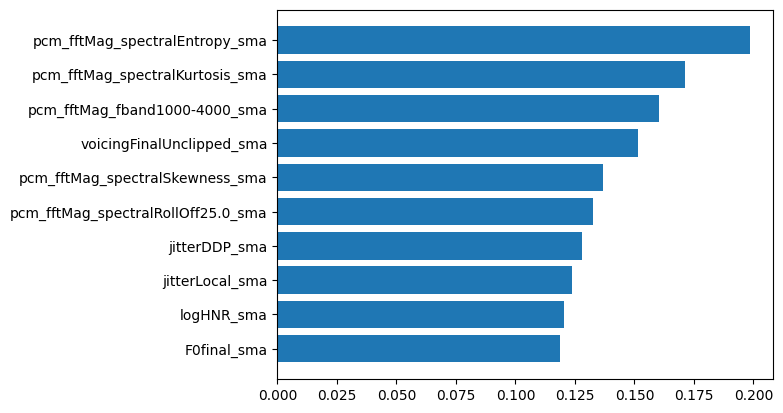

fold:  1
6373 65
[6.79568049e-05 5.34997905e-04 1.62924279e-03 ... 4.13944013e-03
 5.79550793e-04 8.14335208e-04]
[0.11640728 0.1494247  0.10781218 0.11867975 0.09651598 0.08676903
 0.08659013 0.08071089 0.07825456 0.11343076 0.08453258 0.03448068
 0.05896349 0.05892391 0.04721462 0.0502554  0.04445039 0.06046002
 0.07570899 0.05251728 0.03922584 0.03990914 0.06151663 0.05275097
 0.06490399 0.04468164 0.04119045 0.0436677  0.05472803 0.05768656
 0.05225028 0.0512658  0.06865692 0.056728   0.05731482 0.05034978
 0.10940654 0.13600519 0.12962052 0.09819743 0.08404591 0.10954039
 0.0950207  0.09603118 0.18646096 0.09923005 0.13915203 0.15519739
 0.09858893 0.10464837 0.09817016 0.09559394 0.0718442  0.08426945
 0.08085825 0.12060693 0.06658615 0.07734885 0.10941423 0.07529315
 0.07347906 0.07148971 0.08579342 0.06305228 0.09383855]


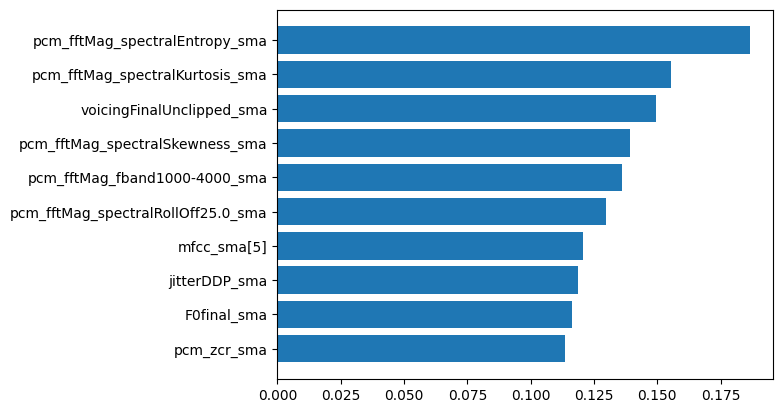

fold:  2
6373 65
[0.00024264 0.0002244  0.0011868  ... 0.0030001  0.0003274  0.0006089 ]
[0.09732237 0.12890498 0.08648099 0.09824765 0.09480056 0.09177795
 0.08029541 0.098857   0.0723117  0.10769318 0.07220649 0.05684821
 0.04217947 0.05128156 0.04994301 0.06223958 0.05482653 0.05283741
 0.06666902 0.04492005 0.04564172 0.0362047  0.06327364 0.06030928
 0.05603366 0.05501407 0.03906073 0.04086486 0.06461952 0.0471052
 0.04116561 0.04304147 0.07374729 0.05294961 0.05365105 0.06924512
 0.11764715 0.13921073 0.14080945 0.10081097 0.09599795 0.09982324
 0.08935863 0.1051403  0.15867699 0.0988214  0.12649611 0.11794237
 0.11332055 0.11422295 0.10405276 0.09618198 0.05245262 0.05877796
 0.0974807  0.11577047 0.05871652 0.05328726 0.07597178 0.05796875
 0.08801009 0.05233614 0.06844159 0.06050956 0.09005138]


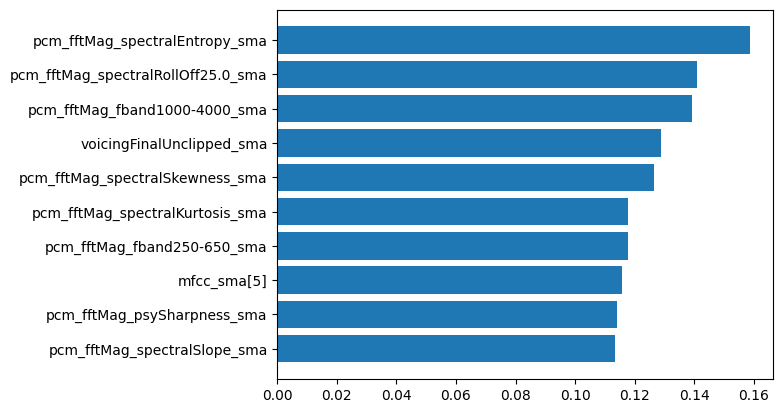

fold:  3
6373 65
[0.00025558 0.00057776 0.00240108 ... 0.00298484 0.00061016 0.00098799]
[0.11003979 0.1147401  0.12988462 0.11314101 0.10989733 0.11471457
 0.10107337 0.0815317  0.10812933 0.0963116  0.05891915 0.05376894
 0.07244634 0.04344593 0.05705219 0.04760095 0.04570284 0.05095124
 0.06795008 0.05592997 0.04632544 0.03798513 0.04849171 0.04424797
 0.05711437 0.06492362 0.0545075  0.03588654 0.04621459 0.04730908
 0.04235384 0.0496598  0.07534035 0.06341396 0.05982025 0.07664047
 0.11288128 0.15949092 0.13573136 0.08645106 0.07654164 0.10580571
 0.11268758 0.09247031 0.18660842 0.09521615 0.13483491 0.19396951
 0.13855442 0.09452172 0.1135319  0.10515188 0.05196741 0.08210309
 0.0815488  0.0818271  0.05941516 0.06231178 0.08057676 0.05794132
 0.0657262  0.05644235 0.06746282 0.05538763 0.10054655]


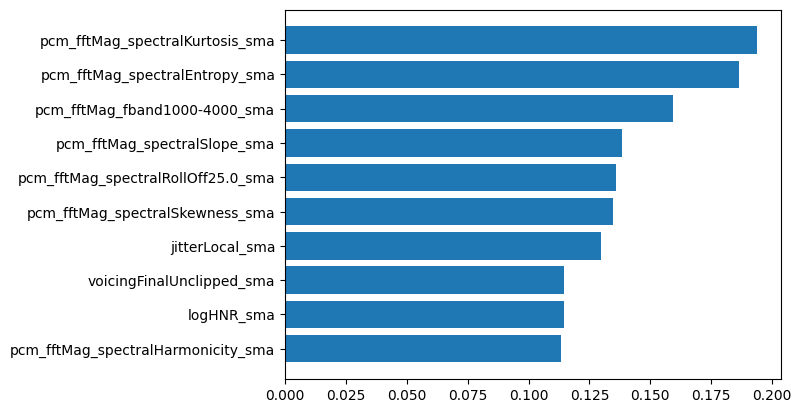

fold:  4
6373 65
[0.00024813 0.00089123 0.00143362 ... 0.00306993 0.00058795 0.00109737]
[0.11313709 0.13158131 0.11608127 0.10775825 0.09349903 0.10296723
 0.11496357 0.09675976 0.10968962 0.11277628 0.07986309 0.0593718
 0.05543487 0.06028498 0.05208864 0.05500826 0.05749079 0.05808787
 0.0643119  0.04403855 0.0473704  0.03900575 0.05864652 0.06226314
 0.0490447  0.05228109 0.04302979 0.05255165 0.05078745 0.05981875
 0.06114026 0.04725047 0.06856835 0.05795406 0.06369529 0.07300817
 0.11930521 0.1700245  0.14545973 0.09599184 0.08780333 0.10775398
 0.13313002 0.09750465 0.17210596 0.11940471 0.14291224 0.15260214
 0.12937569 0.11064047 0.11243108 0.10851409 0.06341819 0.07586308
 0.09498253 0.12890111 0.06233599 0.0723458  0.08884177 0.07585502
 0.06554285 0.07733525 0.08186892 0.06911666 0.11218391]


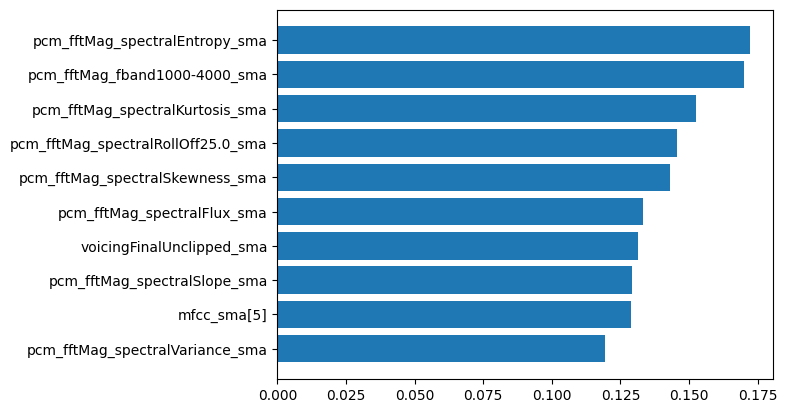

True

In [8]:
main()

In [8]:
import pandas as pd

fivefolds_1k_c = pd.read_csv('biclass_result/acoustic_c.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
fivefolds_1k_c.head(50)

,name,result,truth,hyps
0,15,0,0,0.419551
1,16,1,1,0.738322
2,22,0,0,0.179952
3,28,1,1,0.623367
4,34,0,0,0.219820
5,35,1,1,0.585480
6,40,1,1,0.792304
7,42,0,0,0.211587
8,51,1,0,0.829216
9,53,1,0,0.562181


In [9]:
fivefolds_1k_c.tail(38)

,name,result,truth,hyps
48,82,0,0,1.771955e-01
49,87,0,0,1.741943e-01
50,93,0,0,1.633800e-01
51,98,0,0,2.958482e-01
52,4,0,1,3.649903e-01
53,6,0,0,3.343294e-01
54,7,0,0,1.345569e-01
55,9,0,1,1.903776e-01
56,12,1,1,5.527456e-01
57,17,1,1,5.971278e-01


In [10]:
fivefolds_1_result_c = fivefolds_1k_c['result'].tolist()
fivefolds_1_hyps_c = fivefolds_1k_c['hyps'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
fivefolds_1_truth_c = fivefolds_1k_c['truth'].tolist()

In [11]:
from sklearn import metrics
# print('evs: ', metrics.explained_variance_score(fivefolds_1_truth, fivefolds_1_hyps))
# print('mae: ', metrics.mean_absolute_error(fivefolds_1_truth, fivefolds_1_hyps))
# print('mse: ', metrics.mean_squared_error(fivefolds_1_truth, fivefolds_1_hyps))
# print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_1_truth, fivefolds_1_hyps)))
# print('r2: ', metrics.r2_score(fivefolds_1_truth, fivefolds_1_hyps))

target_names = ['non-patient', 'patient']
print(metrics.classification_report(fivefolds_1_truth_c, fivefolds_1_result_c, target_names=target_names))
tn, fp, fn, tp = metrics.confusion_matrix(fivefolds_1_truth_c, fivefolds_1_result_c).ravel()
print('sensitivuty: ',tp / (fn+tp))
print('specificity: ',tn / (fp+tn))

# # fpr, tpr, thresholds = metrics.roc_curve(np.array(fivefolds_1_truth_c), np.array(fivefolds_1_hyps_c), pos_label=1)
# # print('AUC: ',metrics.auc(fpr, tpr))
# fpr, tpr, thresholds = metrics.roc_curve(np.array(fivefolds_1_truth_c), np.array(fivefolds_1_hyps_c), pos_label=1)
# print('AUC: ',metrics.auc(fpr, tpr))
# fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(fivefolds_1_truth_c[0:19]), np.array(fivefolds_1_hyps_c[0:19]), pos_label=1)
# auc1 = metrics.auc(fpr1, tpr1)
# fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(fivefolds_1_truth_c[19:37]), np.array(fivefolds_1_hyps_c[19:37]), pos_label=1)
# auc2 = metrics.auc(fpr2, tpr2)
# fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(fivefolds_1_truth_c[37:54]), np.array(fivefolds_1_hyps_c[37:54]), pos_label=1)
# auc3 = metrics.auc(fpr3, tpr3)
# fpr4, tpr4, thresholds4 = metrics.roc_curve(np.array(fivefolds_1_truth_c[54:71]), np.array(fivefolds_1_hyps_c[54:71]), pos_label=1)
# auc4 = metrics.auc(fpr4, tpr4)
# fpr5, tpr5, thresholds5 = metrics.roc_curve(np.array(fivefolds_1_truth_c[71:88]), np.array(fivefolds_1_hyps_c[71:88]), pos_label=1)
# auc5 = metrics.auc(fpr5, tpr5)
# print('AUC: ', auc1, auc2, auc3, auc4, auc5)
# print("AUC_avg: ", (auc1+auc2+auc3+auc4+auc5)/5)

f1_scores, sensitivities, specificities, aucs, \
mean_f1, mean_sensitivity, mean_specificity, mean_auc, \
std_f1, std_sensitivity, std_specificity, std_auc, \
conf_interval_f1, conf_interval_sensitivity, conf_interval_specificity, conf_interval_auc = eval_std_ci(fivefolds_1_truth_c, fivefolds_1_hyps_c, fivefolds_1_result_c)
print(f"F1 Scores: {f1_scores}, Sensitivities: {sensitivities}, Specificities: {specificities}, AUCs: {aucs}")
print(f"Mean F1 Score: {mean_f1}, Std Dev: {std_f1}, 95% Confidence Interval: {conf_interval_f1}")
print(f"Mean Sensitivity: {mean_sensitivity}, Std Dev: {std_sensitivity}, 95% Confidence Interval: {conf_interval_sensitivity}")
print(f"Mean Specificity: {mean_specificity}, Std Dev: {std_specificity}, 95% Confidence Interval: {conf_interval_specificity}")
print(f"Mean AUC: {mean_auc}, Std Dev: {std_auc}, 95% Confidence Interval: {conf_interval_auc}")

              precision    recall  f1-score   support

 non-patient       0.83      0.90      0.86        58
     patient       0.74      0.61      0.67        28

    accuracy                           0.80        86
   macro avg       0.78      0.75      0.76        86
weighted avg       0.80      0.80      0.80        86

sensitivuty:  0.6071428571428571
specificity:  0.896551724137931
F1 Scores: [0.7272727272727273, 0.6666666666666666, 0.6, 0.5, 0.8000000000000002], Sensitivities: [1.0, 0.5, 0.5, 0.4, 0.8], Specificities: [0.7692307692307693, 1.0, 0.9090909090909091, 0.9166666666666666, 0.9166666666666666], AUCs: [0.8653846153846154, 0.85, 0.606060606060606, 0.7, 0.95]
Mean F1 Score: 0.6587878787878789, Std Dev: 0.10330800364927285, 95% Confidence Interval: (0.5305140499302735, 0.7870617076454843)
Mean Sensitivity: 0.64, Std Dev: 0.22449944320643647, 95% Confidence Interval: (0.3612471237537767, 0.9187528762462234)
Mean Specificity: 0.9023310023310023, Std Dev: 0.0744467917915814, 

In [13]:
import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)
smile.feature_names

['audspec_lengthL1norm_sma_range',
 'audspec_lengthL1norm_sma_maxPos',
 'audspec_lengthL1norm_sma_minPos',
 'audspec_lengthL1norm_sma_quartile1',
 'audspec_lengthL1norm_sma_quartile2',
 'audspec_lengthL1norm_sma_quartile3',
 'audspec_lengthL1norm_sma_iqr1-2',
 'audspec_lengthL1norm_sma_iqr2-3',
 'audspec_lengthL1norm_sma_iqr1-3',
 'audspec_lengthL1norm_sma_percentile1.0',
 'audspec_lengthL1norm_sma_percentile99.0',
 'audspec_lengthL1norm_sma_pctlrange0-1',
 'audspec_lengthL1norm_sma_stddev',
 'audspec_lengthL1norm_sma_skewness',
 'audspec_lengthL1norm_sma_kurtosis',
 'audspec_lengthL1norm_sma_meanSegLen',
 'audspec_lengthL1norm_sma_maxSegLen',
 'audspec_lengthL1norm_sma_minSegLen',
 'audspec_lengthL1norm_sma_segLenStddev',
 'audspec_lengthL1norm_sma_upleveltime25',
 'audspec_lengthL1norm_sma_upleveltime50',
 'audspec_lengthL1norm_sma_upleveltime75',
 'audspec_lengthL1norm_sma_upleveltime90',
 'audspec_lengthL1norm_sma_risetime',
 'audspec_lengthL1norm_sma_leftctime',
 'audspec_lengthL1

In [14]:
import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
smile.feature_names

['F0final_sma',
 'voicingFinalUnclipped_sma',
 'jitterLocal_sma',
 'jitterDDP_sma',
 'shimmerLocal_sma',
 'logHNR_sma',
 'audspec_lengthL1norm_sma',
 'audspecRasta_lengthL1norm_sma',
 'pcm_RMSenergy_sma',
 'pcm_zcr_sma',
 'audSpec_Rfilt_sma[0]',
 'audSpec_Rfilt_sma[1]',
 'audSpec_Rfilt_sma[2]',
 'audSpec_Rfilt_sma[3]',
 'audSpec_Rfilt_sma[4]',
 'audSpec_Rfilt_sma[5]',
 'audSpec_Rfilt_sma[6]',
 'audSpec_Rfilt_sma[7]',
 'audSpec_Rfilt_sma[8]',
 'audSpec_Rfilt_sma[9]',
 'audSpec_Rfilt_sma[10]',
 'audSpec_Rfilt_sma[11]',
 'audSpec_Rfilt_sma[12]',
 'audSpec_Rfilt_sma[13]',
 'audSpec_Rfilt_sma[14]',
 'audSpec_Rfilt_sma[15]',
 'audSpec_Rfilt_sma[16]',
 'audSpec_Rfilt_sma[17]',
 'audSpec_Rfilt_sma[18]',
 'audSpec_Rfilt_sma[19]',
 'audSpec_Rfilt_sma[20]',
 'audSpec_Rfilt_sma[21]',
 'audSpec_Rfilt_sma[22]',
 'audSpec_Rfilt_sma[23]',
 'audSpec_Rfilt_sma[24]',
 'audSpec_Rfilt_sma[25]',
 'pcm_fftMag_fband250-650_sma',
 'pcm_fftMag_fband1000-4000_sma',
 'pcm_fftMag_spectralRollOff25.0_sma',
 'pcm_ff